1. IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [31]:
import os
import numpy as np
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2. TIỀN XỬ LÝ DỮ LIỆU:

In [32]:
# Load dữ liệu
def load_dataset_from_dir(data_dir, img_size=(32,32)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d)))
    label_map = {cls:i for i,cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                path = os.path.join(cls_dir, fname)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)                   
                img = img.astype(np.float16) / 255.0              
                X.append(img)
                y.append(cls)                                     

    X = np.array(X)                                         
    y = np.array(y)

    return X, y, label_map


# Đọc dữ liệu
dataset_path_train = '/kaggle/input/cus-hand-written/hand_written_digit/train'
dataset_path_test = '/kaggle/input/cus-hand-written/hand_written_digit/test'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(32,32))
X_test, y_test, label_map_test = load_dataset_from_dir(dataset_path_test, img_size=(32,32))
print(f"Tổng số ảnh train: {len(X_train)}")
print(f"Tổng số ảnh test: {len(X_test)}")

Tổng số ảnh train: 3482
Tổng số ảnh test: 778


In [33]:
# Encode nhãn và chia dữ liệu train/test
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.fit_transform(y_test)
num_classes = len(le.classes_)

print(y_train_num)

[0 0 0 ... 9 9 9]


In [34]:
# Chia tập train-valid tỉ lệ 8-2
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num, test_size=0.2, random_state=42, stratify=y_train_num
)

print(f"Số ảnh TRAIN: {len(X_train_sub)}")
print(f"Số ảnh VALIDATION: {len(X_val)}")
print(f"Tổng số ảnh test: {len(X_test)}")

Số ảnh TRAIN: 2785
Số ảnh VALIDATION: 697
Tổng số ảnh test: 778


In [35]:
# One-hot encode Y
Y_train = to_categorical(y_train_sub, num_classes)
Y_val = to_categorical(y_val, num_classes)
Y_test = to_categorical(y_test, num_classes)

print(Y_train)
print(Y_val)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


3. XÂY DỰNG MÔ HÌNH

In [6]:
# Load mô hình VGG16 đã huấn luyện trước
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Đóng băng các lớp của VGG16 (chỉ fine-tune các lớp mới)
for layer in vgg16.layers:
    layer.trainable = False  # Các lớp của VGG16 sẽ không được huấn luyện lại

# Thêm các lớp mới cho bài toán phân loại
x = Flatten()(vgg16.output)  # Biến đầu ra thành một vector
x = Dense(256, activation='relu')(x)  # Lớp Fully Connected
x = Dropout(0.5)(x)  # Dropout để giảm overfitting
output = Dense(num_classes, activation='softmax')(x)  # Lớp phân loại

I0000 00:00:1750415169.685448      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750415169.686111      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Tạo mô hình mới từ VGG16 + các lớp phân loại mới
model = Model(inputs=vgg16.input, outputs=output)

# Tóm tắt mô hình
model.summary()

# Compile mô hình
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback cho việc dừng sớm nếu mô hình không cải thiện
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

4. HUẤN LUYỆN MÔ HÌNH CNN

In [ ]:
# Huấn luyện mô hình
H = model.fit(
    X_train_sub, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/500


I0000 00:00:1750415173.748666      65 service.cc:148] XLA service 0x7bd0e8009790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750415173.748999      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750415173.749022      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750415174.120407      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


22/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0934 - loss: 2.5124

I0000 00:00:1750415176.933338      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.1182 - loss: 2.3993 - val_accuracy: 0.2224 - val_loss: 2.1559
Epoch 2/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1976 - loss: 2.1596 - val_accuracy: 0.2726 - val_loss: 2.0693
Epoch 3/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2084 - loss: 2.1046 - val_accuracy: 0.2812 - val_loss: 2.0048
Epoch 4/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2478 - loss: 2.0434 - val_accuracy: 0.3085 - val_loss: 1.9710
Epoch 5/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2774 - loss: 1.9755 - val_accuracy: 0.2970 - val_loss: 1.9237
Epoch 6/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2981 - loss: 1.9172 - val_accuracy: 0.3271 - val_loss: 1.8773
Epoch 7/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3242 - loss: 1.9101 - val_accuracy: 0.3386 - val_loss: 1.8445
Epoch 8/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3367 - loss: 1.8763 - val_accuracy: 0.3759 - val_

In [9]:
# Lưu lại mô hình đã fine-tune
os.makedirs("/kaggle/working", exist_ok=True)
model.save("/kaggle/working/vgg16_finetuned_model.keras")

5. VISUALIZATION

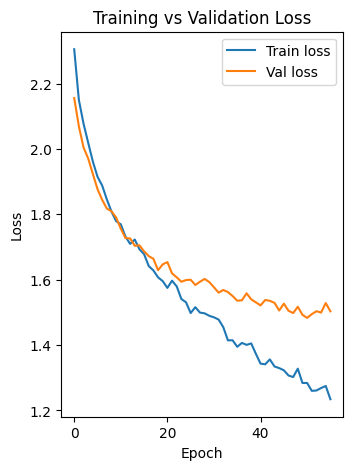

<function matplotlib.pyplot.show(close=None, block=None)>

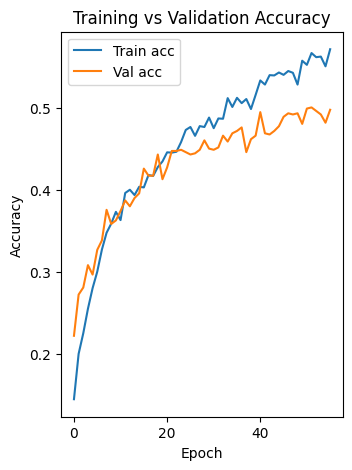

In [10]:
# 12. Vẽ đồ thị loss và accuracy của training & validation
# Loss
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Train loss')
plt.plot(H.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Train acc')
plt.plot(H.history['val_accuracy'], label='Val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show


6. Đánh giá trên tập test

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model = load_model('/kaggle/working/vgg16_finetuned_model.keras')

# Dự đoán nhãn trên tập test
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# In classification report
print("=== Classification Report trên tập TEST ===")
print(classification_report(y_test_num, y_test_pred, target_names=le.classes_))

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
=== Classification Report trên tập TEST ===
              precision    recall  f1-score   support

           0       0.57      0.47      0.51        77
           1       0.39      0.62      0.48        77
           2       0.35      0.31      0.33        78
           3       0.35      0.35      0.35        80
           4       0.39      0.49      0.44        75
           5       0.44      0.47      0.46        76
           6       0.55      0.31      0.39        78
           7       0.44      0.43      0.43        79
           8       0.50      0.43      0.46        79
           9       0.35      0.34      0.35        79

    accuracy                           0.42       778
   macro avg       0.43      0.42      0.42       778
weighted avg       0.43      0.42      0.42       778



7. Dự đoán trên tập dữ liệu Predict

In [11]:
import os
import cv2
import numpy as np

model = load_model('/kaggle/working/vgg16_finetuned_model.keras')

# Hàm dự đoán và lưu kết quả
def predict_and_save_results(model, data_dir, img_size=(32,32)):
    X, filenames = [], []
    
    # Kiểm tra lại img_size có đúng định dạng không
    if not isinstance(img_size, tuple) or len(img_size) != 2:
        raise ValueError(f"img_size phải là một tuple có 2 phần tử. Hiện tại là {img_size}")
    
    # Duyệt qua tất cả các file trong thư mục dữ liệu
    for fname in os.listdir(data_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Lọc các ảnh
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đổi sang RGB
            
            # Resize hình ảnh về kích thước 32x32
            img = cv2.resize(img, img_size)  # Resize ảnh
            img = img.astype(np.float16) / 255.0  # Chuẩn hóa ảnh
            X.append(img)
            filenames.append(fname)
    
    # Chuyển X thành mảng numpy
    X = np.array(X)
    
    # Dự đoán nhãn
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)  # Lấy nhãn có xác suất cao nhất

    # Lưu kết quả vào file CSV với định dạng tên file và nhãn
    result_file = '/kaggle/working/predictions.csv'
    with open(result_file, 'w') as f:
        for fname, predicted_class in zip(filenames, predicted_classes):
            # Đảm bảo giữ nguyên tên file đầy đủ (bao gồm phần mở rộng)
            f.write(f"{fname},{predicted_class}\n")
    
    print(f"Results saved to {result_file}")

# Dự đoán cho bộ test
dataset_path_test = '/kaggle/input/hand-written'
predict_and_save_results(model, dataset_path_test)

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Results saved to /kaggle/working/predictions.csv
